In [10]:
# 🟩 STEP 4: Set up and Extract Dataset Locally (VS Code)
import os
import zipfile

# --- Configuration ---
# 1. The name of your dataset zip file.
ZIP_FILE_PATH = 'dataset.zip'
# 2. The directory where the dataset contents (train, test folders) will be extracted.
# We create a new folder named 'content' in the same directory as the notebook.
EXTRACT_PATH = './content/'

# The notebook uses '/content' in later steps (STEP 3).
# You must update this path in STEP 3 as well!
# Update the base_dir in STEP 3 to: base_dir = EXTRACT_PATH

# ---------------------

# Check if the dataset folder already exists before extracting
if not os.path.exists(EXTRACT_PATH):
    print(f"Extracting {ZIP_FILE_PATH} to {EXTRACT_PATH}...")
    try:
        # Open and extract the ZIP file contents
        with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
            # Note: Your zip file contents will be inside './content/dataset/' if the root folder is 'dataset'
            zip_ref.extractall(EXTRACT_PATH)
        print("Extraction complete.")
    except FileNotFoundError:
        print(f"Error: {ZIP_FILE_PATH} not found. Make sure the file is in the same folder as this notebook.")
else:
    print(f"Dataset already extracted to {EXTRACT_PATH}. Skipping extraction.")

Dataset already extracted to ./content/. Skipping extraction.


In [11]:
# 🟩 STEP 3: Dataset directories (Updated for VS Code)
import os
# Change the base directory from Colab's '/content' to your local extraction path.
base_dir = './content/' # Assuming extraction to ./content/

# Check your extraction: if the actual data folders (train, test) are nested, 
# you might need 'base_dir = './content/dataset/' 

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
assert os.path.exists(train_dir), "Train folder not found. Check if the path is correct (e.g., nesting in 'dataset')."
assert os.path.exists(test_dir), "Test folder not found. Check if the path is correct (e.g., nesting in 'dataset')."

In [15]:
# 🟩 STEP 5: Improved nail cropping + square with less black
import cv2
import numpy as np

def crop_square_nail_loose(img, margin=0.3):
    """
    Crop a roughly detected nail area, make it square, reduce black padding.
    Looser margin helps include more context around the nail.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return cv2.resize(img, (224, 224))  # fallback

    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    # Looser margin to include more of surrounding skin
    mx = int(w * margin)
    my = int(h * margin)
    x1 = max(0, x - mx)
    y1 = max(0, y - my)
    x2 = min(img.shape[1], x + w + mx)
    y2 = min(img.shape[0], y + h + my)

    cropped = img[y1:y2, x1:x2]

    # Make square by padding with edge values instead of black
    size = max(cropped.shape[:2])
    square = cv2.copyMakeBorder(
        cropped,
        top=(size - cropped.shape[0]) // 2,
        bottom=(size - cropped.shape[0] + 1) // 2,
        left=(size - cropped.shape[1]) // 2,
        right=(size - cropped.shape[1] + 1) // 2,
        borderType=cv2.BORDER_REPLICATE  # repeats edge pixels
    )

    return cv2.resize(square, (224, 224))

def enhance_nail_image_loose(img):
    img = np.array(img, dtype=np.uint8)
    img = crop_square_nail_loose(img)
    img = img / 255.0  # gentle normalization
    return img


In [16]:
# 🟩 STEP 6: Data generators with safer augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.03,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=enhance_nail_image_loose
)

test_datagen = ImageDataGenerator(
    preprocessing_function=enhance_nail_image_loose
)

Found 420 images belonging to 12 classes.


Found 180 images belonging to 12 classes.


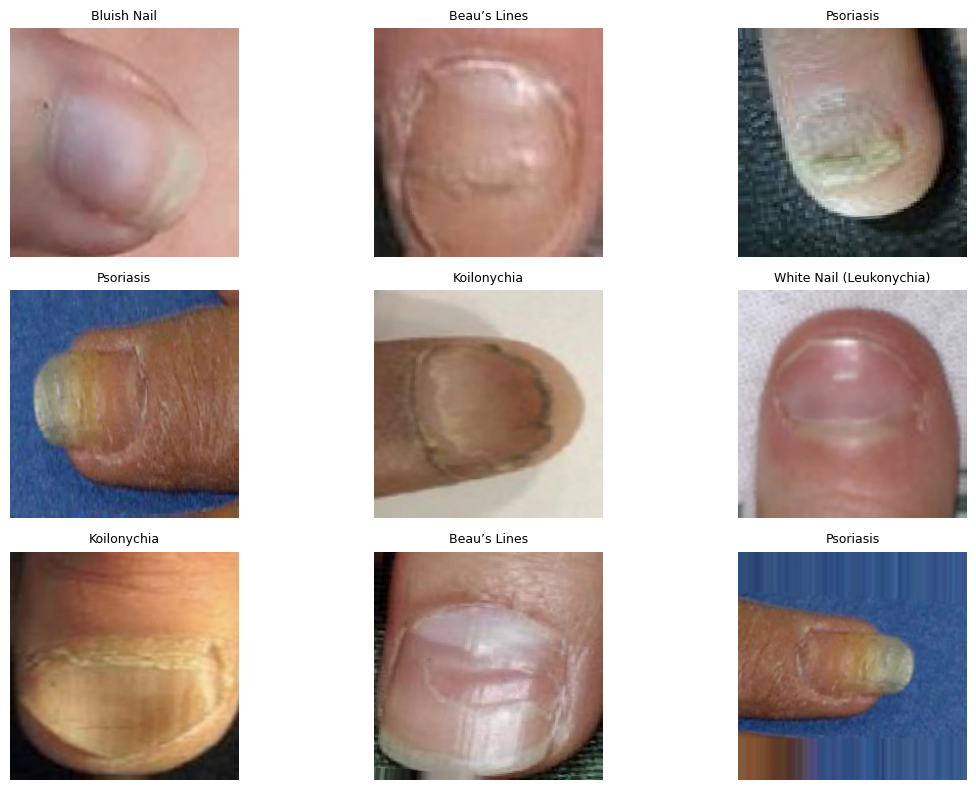

In [26]:
# 🟩 STEP 7: Visualize 9 clean samples
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


images, labels = next(train_generator) # Use train_generator here
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    label_name = list(train_generator.class_indices.keys())[label_idx] # Use train_generator here
    plt.title(label_name, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [27]:
# 🟩 STEP 8: Display class labels with numeric indices
for class_name, class_index in train_generator.class_indices.items():
    print(f"{class_index} → {class_name}")

0 → Acral Lentiginous Melanoma
1 → Beau’s Lines
2 → Bluish Nail
3 → Clubbing
4 → Healthy Nail
5 → Koilonychia
6 → Onychogryphosis
7 → Onychomycosis
8 → Pitting
9 → Psoriasis
10 → White Nail (Leukonychia)
11 → Yellow Nail
